# clustering the dataset

## loading the dataset

In [1]:
%pip install orjson

Note: you may need to restart the kernel to use updated packages.


In [1]:
import orjson

dataset = []
with open("../dataset.jsonl", "r") as f:
  for line in f:
    dataset.append(orjson.loads(line))

queries = [data['query'] for data in dataset]
codes = [data['code'] for data in dataset]

### loading models

In [2]:
%pip install bertopic sentence-transformers transformers umap-learn hdbscan

Note: you may need to restart the kernel to use updated packages.


In [3]:
from sentence_transformers import SentenceTransformer
import numpy as np

query_model = SentenceTransformer("all-MiniLM-L6-v2")
code_model  = SentenceTransformer("microsoft/codebert-base")

query_embeddings = query_model.encode(queries, show_progress_bar=True)
code_embeddings  = code_model.encode(codes, show_progress_bar=True)

embeddings = np.hstack((query_embeddings, code_embeddings))

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

No sentence-transformers model found with name microsoft/codebert-base. Creating a new one with mean pooling.


config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

In [98]:
import pandas as pd
from bertopic import BERTopic
texts = [f"{q} {c}" for q, c in zip(queries, codes)]
from umap import UMAP
umap_model = UMAP(n_neighbors=15, n_components=5, metric='cosine', random_state=42, verbose=True)
from hdbscan import HDBSCAN
# hdbscan_model = HDBSCAN(min_cluster_size=13, metric='euclidean', prediction_data=True)
hdbscan_model = HDBSCAN(metric='euclidean', prediction_data=True)
variable_topic_model = BERTopic(umap_model=umap_model, hdbscan_model=hdbscan_model, calculate_probabilities=True, verbose=True)
variable_topics, variable_probs = variable_topic_model.fit_transform(texts, embeddings)

2025-05-26 15:18:45,843 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


UMAP(angular_rp_forest=True, metric='cosine', n_components=5, n_jobs=1, random_state=42, verbose=True)
Mon May 26 15:18:45 2025 Construct fuzzy simplicial set
Mon May 26 15:18:46 2025 Finding Nearest Neighbors
Mon May 26 15:18:46 2025 Finished Nearest Neighbor Search
Mon May 26 15:18:46 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs


2025-05-26 15:18:48,789 - BERTopic - Dimensionality - Completed ✓
2025-05-26 15:18:48,790 - BERTopic - Cluster - Start clustering the reduced embeddings


	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon May 26 15:18:48 2025 Finished embedding


2025-05-26 15:18:49,014 - BERTopic - Cluster - Completed ✓
2025-05-26 15:18:49,018 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-26 15:18:49,114 - BERTopic - Representation - Completed ✓


In [99]:
import pandas as pd
variable_info = pd.DataFrame(variable_topic_model.get_topic_info())
print(variable_info['Topic'].unique())
variable_info.head()

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62]


,Topic,Count,Name,Representation,Representative_Docs
0,-1,141,-1_year_function_num2_test,"[year, function, num2, test, assert, return, f...",[Test a function that checks if a given key ex...
1,0,70,0_httpserver_basehttprequesthandler_selfsendre...,"[httpserver, basehttprequesthandler, selfsendr...",[This code shows how to create a basic server ...
2,1,60,1_class_initself_breed_name,"[class, initself, breed, name, dog, selfname, ...",[Create a simple class representing a Dog with...
3,2,59,2_socketsocketsocketafinet_socket_socketsockst...,"[socketsocketsocketafinet, socket, socketsocks...",[Create a simple TCP client that connects to a...
4,3,40,3_numbers_list_of_sumnumbers,"[numbers, list, of, sumnumbers, 15, sortednumb...",[Determine the minimum value in a list of numb...


In [100]:
from typing import List

variable_all_topics: List[int] = list(map(int, list(variable_topic_model.get_topics().keys())))
if -1 in variable_all_topics:
  variable_all_topics.remove(-1)

In [105]:
variable_topic_model.visualize_barchart(topics=variable_all_topics, top_n_topics=3)

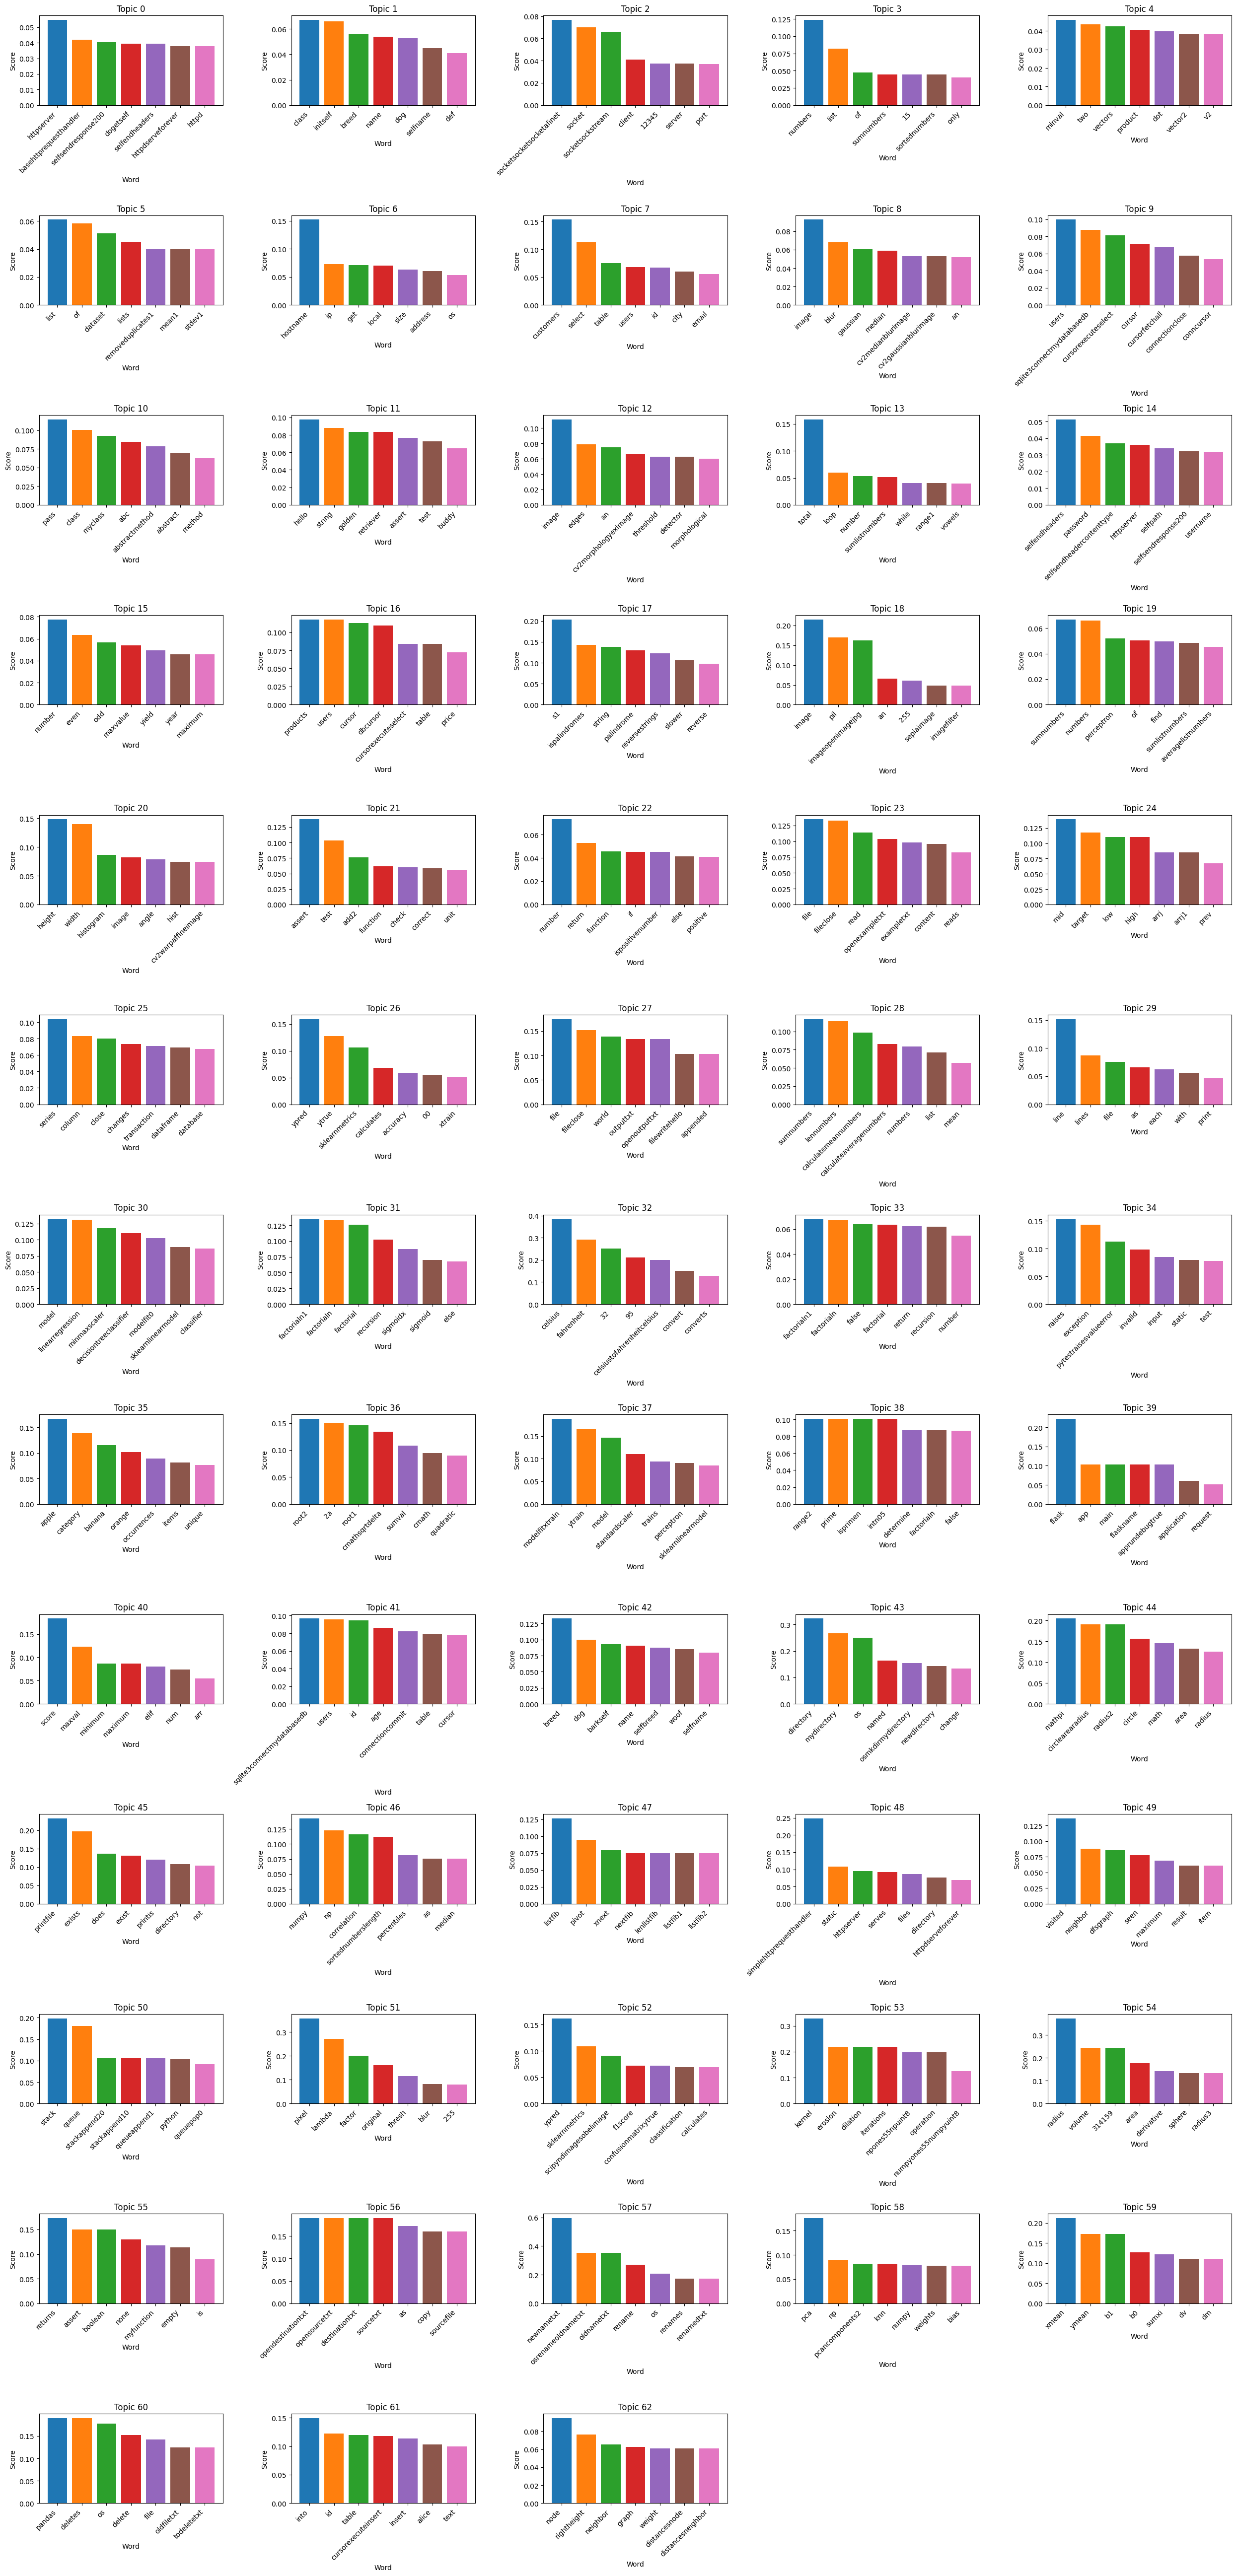

In [106]:
import matplotlib.pyplot as plt
import numpy as np
topics = variable_all_topics  # or constant_all_topics
n_topics = len(topics)
top_n_words = 7  # Number of words per topic
colors = plt.cm.tab10.colors  # 10 distinct colors, you can use only 7 if you want

# Grid setup
n_cols = 5
n_rows = int(np.ceil(n_topics / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()

for idx, topic in enumerate(topics):
    words_scores = variable_topic_model.get_topic(topic)[:top_n_words]
    words = [w for w, _ in words_scores]
    scores = [s for _, s in words_scores]
    ax = axes[idx]
    color_cycle = [colors[i % 7] for i in range(len(words))]
    ax.bar(words, scores, color=color_cycle)
    ax.set_title(f"Topic {topic}")
    ax.set_xticklabels(words, rotation=45, ha='right')
    ax.set_ylabel("Score")
    ax.set_xlabel("Word")

# Hide unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

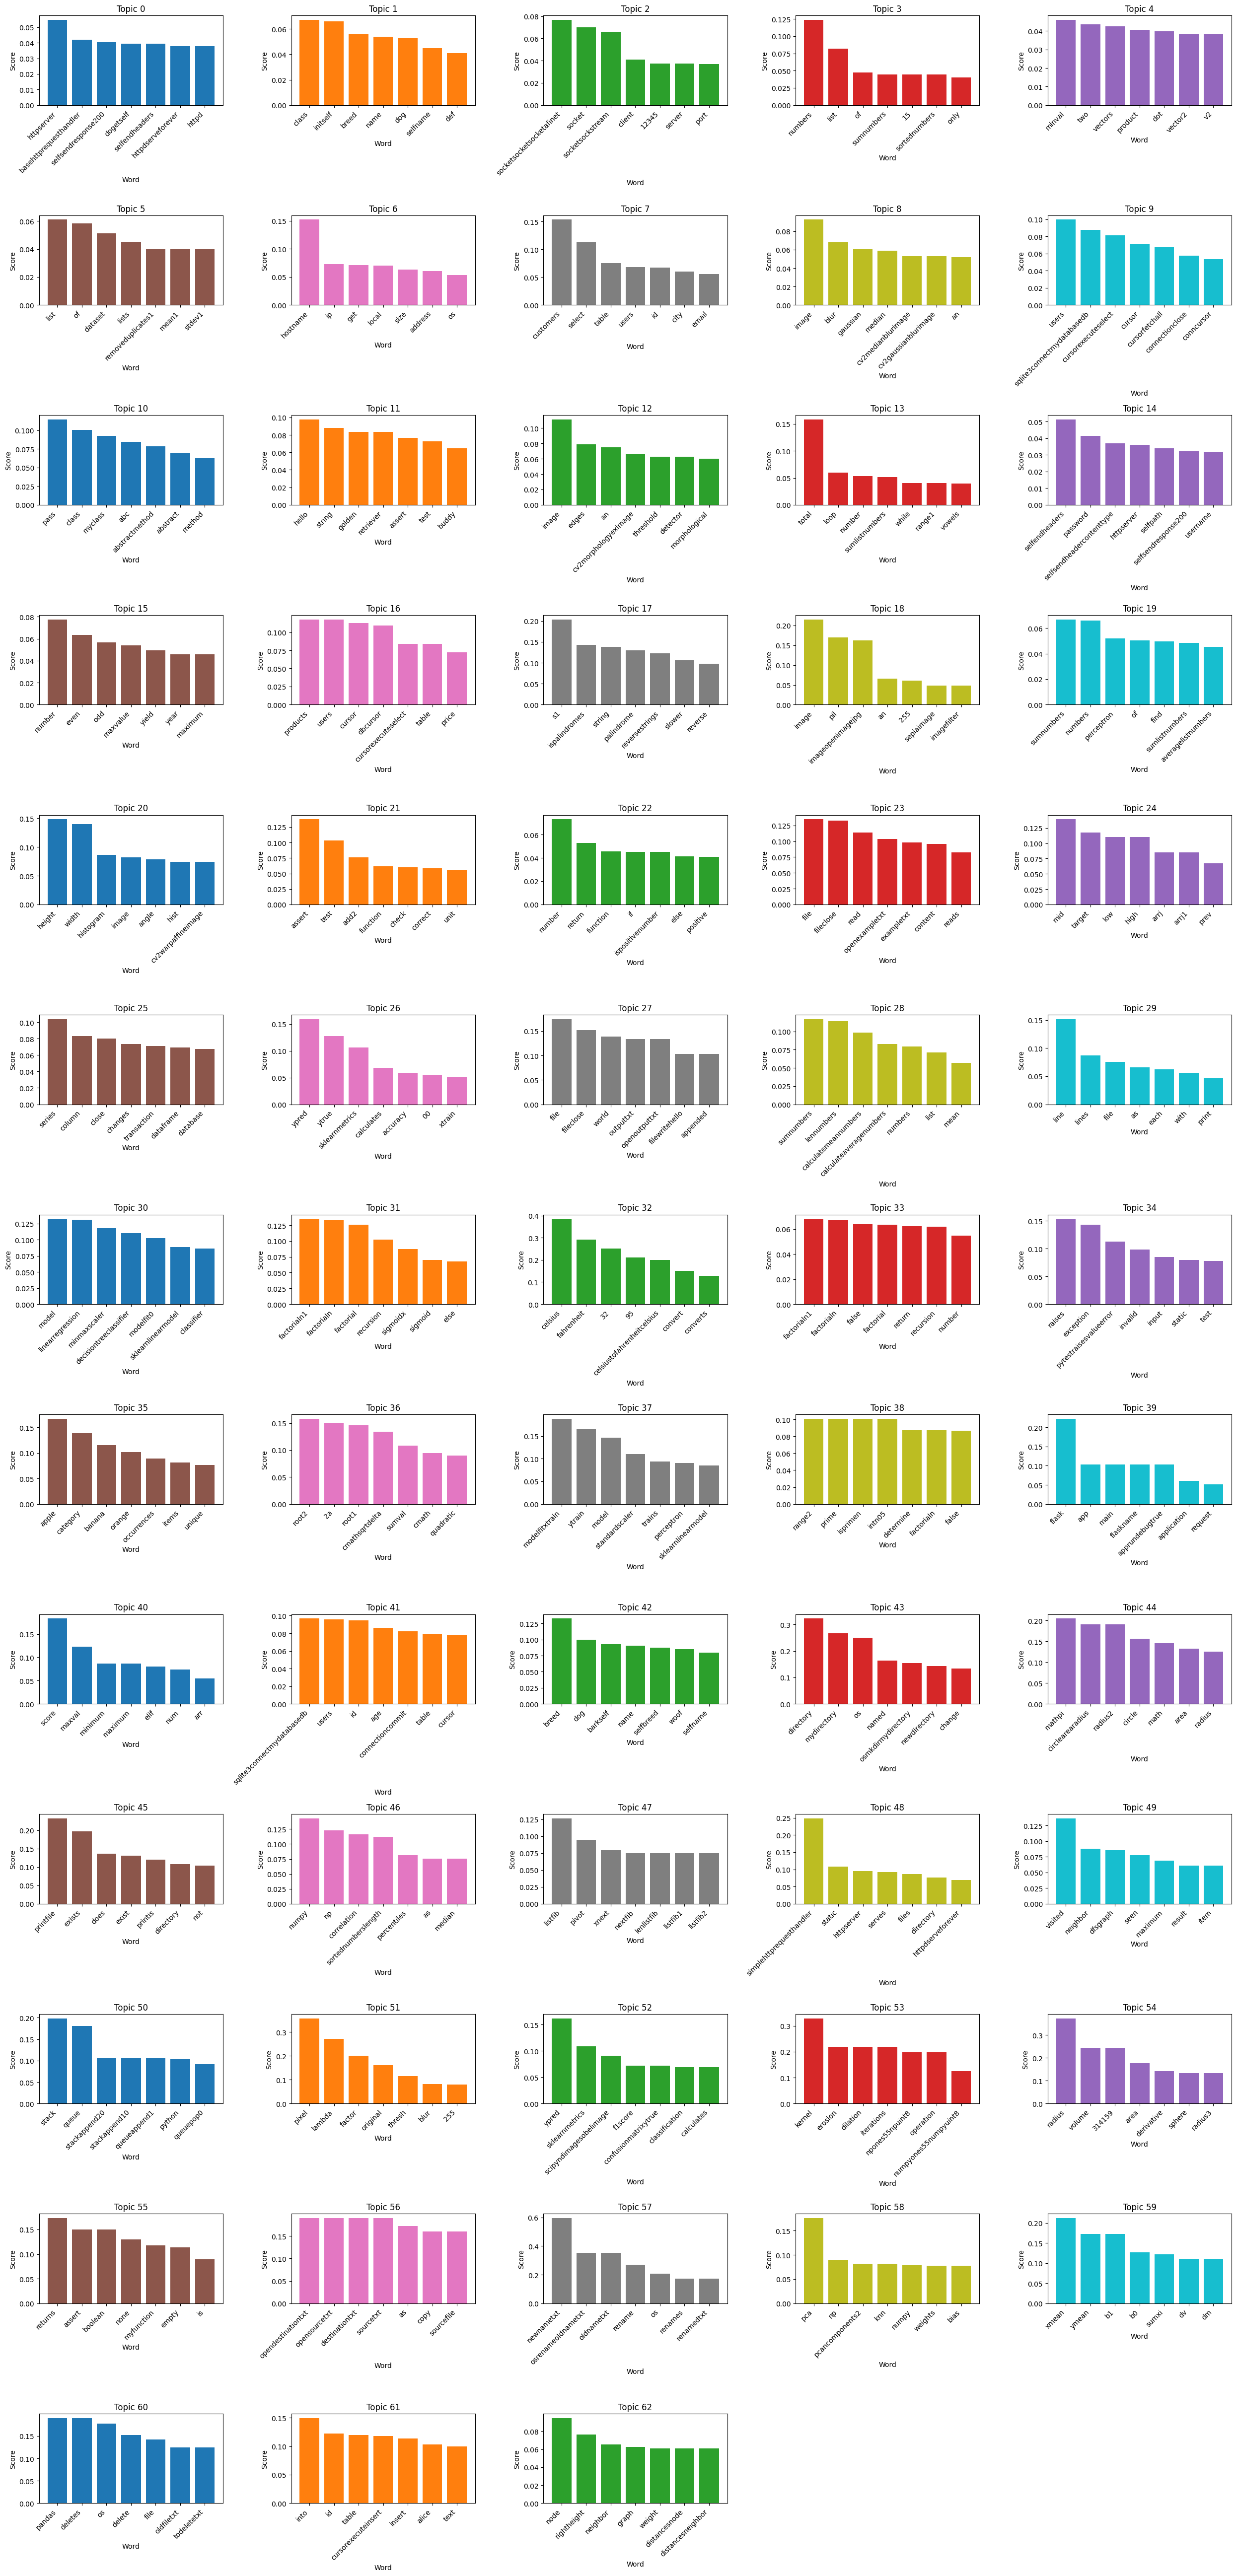

In [107]:
import matplotlib.pyplot as plt
import numpy as np

topics = variable_all_topics  # or constant_all_topics
n_topics = len(topics)
top_n_words = 7
colors = plt.cm.tab10.colors  # 10 distinct colors

n_cols = 5
n_rows = int(np.ceil(n_topics / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()

for idx, topic in enumerate(topics):
    words_scores = variable_topic_model.get_topic(topic)[:top_n_words]
    words = [w for w, _ in words_scores]
    scores = [s for _, s in words_scores]
    ax = axes[idx]
    color = colors[idx % 10]  # Use one color per chart, cycle through 10 colors
    ax.bar(words, scores, color=color)
    ax.set_title(f"Topic {topic}")
    ax.set_xticklabels(words, rotation=45, ha='right')
    ax.set_ylabel("Score")
    ax.set_xlabel("Word")

# Hide unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [102]:
variable_topic_model.visualize_hierarchy()

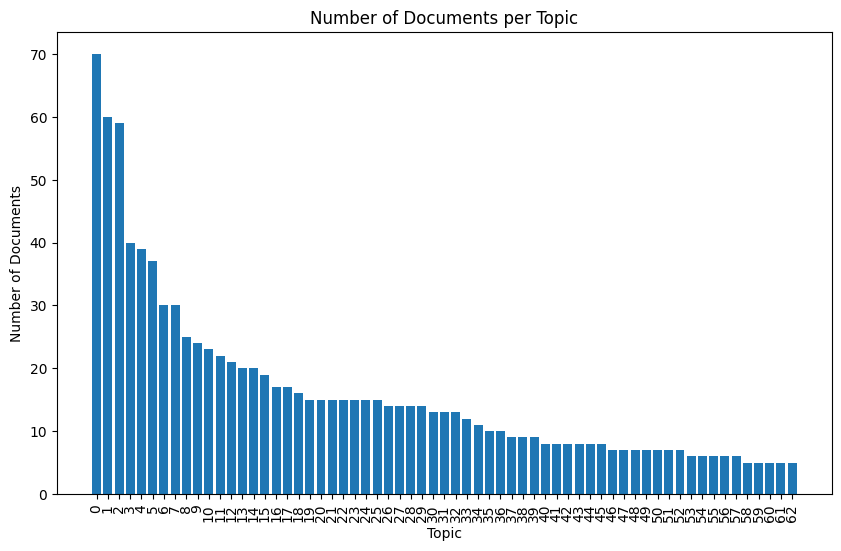

In [103]:
import matplotlib.pyplot as plt
variable_info = variable_topic_model.get_topic_info()
variable_info = variable_info[variable_info.Topic != -1]
plt.figure(figsize=(10, 6))
plt.bar(variable_info.Topic.astype(str), variable_info.Count)
plt.xlabel("Topic")
plt.ylabel("Number of Documents")
plt.title("Number of Documents per Topic")
plt.xticks(rotation=90)
plt.show()

In [104]:
plt = variable_topic_model.visualize_heatmap()
plt.update_xaxes(tickangle=90)
plt.show()

In [63]:
from sklearn.cluster import KMeans
from bertopic import BERTopic
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
embeddings = pca.fit_transform(embeddings)
kmeans_model = KMeans(n_clusters=12, random_state=42)
labels = kmeans_model.fit_predict(embeddings)
constant_topic_model = BERTopic(calculate_probabilities=True, verbose=True, nr_topics=13, min_topic_size=15)
constant_topic_model.fit(texts, embeddings, y=labels)

2025-05-26 15:15:24,738 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-26 15:15:26,570 - BERTopic - Dimensionality - Completed ✓
2025-05-26 15:15:26,572 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-26 15:15:26,678 - BERTopic - Cluster - Completed ✓
2025-05-26 15:15:26,679 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-05-26 15:15:26,743 - BERTopic - Representation - Completed ✓
2025-05-26 15:15:26,744 - BERTopic - Topic reduction - Reducing number of topics
2025-05-26 15:15:26,752 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-26 15:15:26,803 - BERTopic - Representation - Completed ✓
2025-05-26 15:15:26,805 - BERTopic - Topic reduction - Reduced number of topics from 19 to 13


In [64]:
import pandas as pd
info = pd.DataFrame(constant_topic_model.get_topic_info())
print(info['Topic'].unique())
info.head()

[-1  0  1  2  3  4  5  6  7  8  9 10 11]


,Topic,Count,Name,Representation,Representative_Docs
0,-1,3,-1_processedstring_palindrome_joincharlower_pr...,"[processedstring, palindrome, joincharlower, p...",[Create a function that checks if a string is ...
1,0,162,0_httpserver_selfendheaders_basehttprequesthan...,"[httpserver, selfendheaders, basehttprequestha...",[This code shows how to create a basic server ...
2,1,160,1_of_image_the_return,"[of, image, the, return, code, this, def, an, ...",[This code calculates the mean of a list of nu...
3,2,146,2_assert_test_the_function,"[assert, test, the, function, customers, that,...",[Test a function that checks if a number is ev...
4,3,112,3_numbers_list_import_of,"[numbers, list, import, of, numpy, this, code,...",[This code calculates the mean of a list of nu...


In [65]:
constant_all_topics = list(map(int,list(constant_topic_model.get_topics().keys())))
if -1 in constant_all_topics:
  constant_all_topics.remove(-1)

In [66]:
constant_topic_model.visualize_barchart(top_n_topics=None, topics=constant_all_topics)

In [67]:
constant_topic_model.visualize_hierarchy()

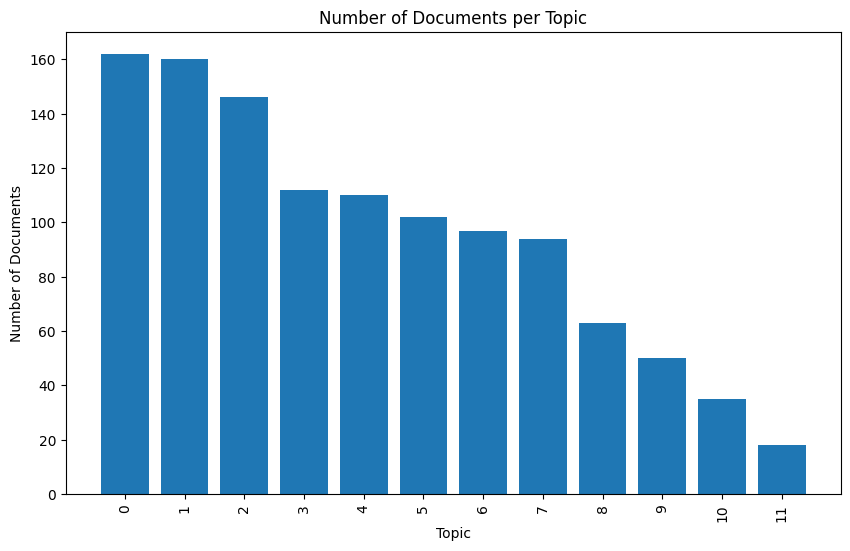

In [68]:
import matplotlib.pyplot as plt
constant_info = constant_topic_model.get_topic_info()
constant_info = constant_info[constant_info.Topic != -1]
plt.figure(figsize=(10, 6))
plt.bar(constant_info.Topic.astype(str), constant_info.Count)
plt.xlabel("Topic")
plt.ylabel("Number of Documents")
plt.title("Number of Documents per Topic")
plt.xticks(rotation=90)
plt.show()

In [69]:
fig = constant_topic_model.visualize_heatmap()
fig.update_xaxes(tickangle=90)  
fig.show()